In [1]:
import sys, os

import numpy as np
from umap import UMAP
import time
import torch
import matplotlib.pyplot as plt
import pandas as pd  
import scanpy as sc
import scipy.sparse as sps
import scipy.io as sio
# import scipy.sparse as sp
from os.path import join

import scmomat 

plt.rcParams["font.size"] = 10

/home/yanxh/anaconda3/envs/multi-omics/lib/python3.8/site-packages/umap_learn-0.5.3-py3.8.egg/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/yanxh/anaconda3/envs/multi-omics/lib/python3.8/site-packages/umap_learn-0.5.3-py3.8.egg/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/yanx

## Step 1: Load dataset

In [2]:
dat_dir = "/home/yanxh/gitrepo/multi-omics-matching/neurips2021_multimodal_topmethods-main/output/datasets/"
data_dir = os.path.join(dat_dir, "match_modality/openproblems_bmmc_cite_phase2_mod2")
out_dir = '/home/yanxh/gitrepo/multi-omics-matching/neurips2021_multimodal_topmethods-main/output/pretrain/scmomat/bm-cite'

In [3]:
print('Reading `h5ad` files...')
input_train_mod1 = sc.read_h5ad(join(data_dir, 'openproblems_bmmc_cite_phase2_mod2.censor_dataset.output_train_mod1.h5ad'))
input_train_mod2 = sc.read_h5ad(join(data_dir, 'openproblems_bmmc_cite_phase2_mod2.censor_dataset.output_train_mod2.h5ad'))
input_train_sol = sc.read_h5ad(join(data_dir, 'openproblems_bmmc_cite_phase2_mod2.censor_dataset.output_train_sol.h5ad'))
input_test_mod1 = sc.read_h5ad(join(data_dir, 'openproblems_bmmc_cite_phase2_mod2.censor_dataset.output_test_mod1.h5ad'))
input_test_mod2 = sc.read_h5ad(join(data_dir, 'openproblems_bmmc_cite_phase2_mod2.censor_dataset.output_test_mod2.h5ad'))

print("Unscrambling training cells...")
ord = input_train_sol.X.tocsr().indices
train_mod2_ord = ord.copy()
if "pairing_ix" in input_train_sol.uns:
    assert np.all(ord == np.argsort(input_train_sol.uns["pairing_ix"]))
input_train_mod2 = input_train_mod2[ord, :].copy()
input_train_mod2.obs_names = input_train_mod1.obs_names

meta_dir = '/home/yanxh/gitrepo/multi-omics-matching/neurips2021_multimodal_topmethods-main'
df_meta = pd.read_csv(os.path.join(meta_dir, 'output/datasets/cite_meta.csv'), index_col=0)

Reading `h5ad` files...
Unscrambling training cells...


## down scale data

In [4]:
sc.pp.highly_variable_genes(input_train_mod2, layer='counts', flavor='seurat_v3', n_top_genes=5000, batch_key='batch')
hvg_names = input_train_mod2.var.query('highly_variable').index.to_numpy()

### format data

In [5]:
genes = hvg_names
proteins = input_train_mod1.var_names.to_numpy()
feats_name = {"rna": genes, "adt": proteins}

# split batches
train_batches = input_train_mod1.obs.batch.to_numpy()
test1_batches = input_test_mod1.obs.batch.to_numpy()
test2_batches = input_test_mod2.obs.batch.to_numpy()

train_batches_barcodes, train_batches_list, train_mods = [], [], []
for bi in np.unique(train_batches):
    b_mask = train_batches == bi
    train_batches_barcodes.append(input_train_mod1.obs_names[b_mask].to_numpy())
    train_batches_list.append([bi]*(b_mask.sum()))
    train_mods.append(['multiome']*(b_mask.sum()))
test1_batches_barcodes, test1_batches_list, test1_mods = [], [], []
for bi in np.unique(test1_batches):
    b_mask = test1_batches == bi
    test1_batches_barcodes.append(input_test_mod1.obs_names[b_mask].to_numpy())
    test1_batches_list.append([bi]*b_mask.sum())
    test1_mods.append(['adt']*(b_mask.sum()))
test2_batches_barcodes, test2_batches_list, test2_mods = [], [], []
for bi in np.unique(test2_batches):
    b_mask = test2_batches == bi
    test2_batches_barcodes.append(input_test_mod2.obs_names[b_mask].to_numpy())
    test2_batches_list.append([bi]*b_mask.sum())
    test2_mods.append(['rna']*(b_mask.sum()))
    
barcodes = [*train_batches_barcodes, *test1_batches_barcodes, *test2_batches_barcodes]
batches = [*train_batches_list, *test1_batches_list, *test2_batches_list]
mods = [*train_mods, *test1_mods, *test2_mods]

n_batches = len(barcodes)

In [6]:
# READ IN THE COUNT MATRICES
# scRNA-seq of batch
counts_rnas = []
for bc in train_batches_barcodes:
    count = scmomat.preprocess(input_train_mod2[bc, hvg_names].layers['counts'].A, modality = "RNA", log = False)
    counts_rnas.append(count)
for bc in test1_batches_barcodes:
    counts_rnas.append(None)
for bc in test2_batches_barcodes:
    count = scmomat.preprocess(input_test_mod2[bc, hvg_names].layers['counts'].A, modality = "RNA", log = False)
    counts_rnas.append(count)

counts_adts = []
for bc in train_batches_barcodes:
    count = scmomat.preprocess(input_train_mod1[bc,].layers['counts'].A, modality = "ADT", log = True)
    counts_adts.append(count)
for bc in test1_batches_barcodes:
    count = scmomat.preprocess(input_test_mod1[bc,].layers['counts'].A, modality = "ADT", log = True)
    counts_adts.append(count)
for bc in test2_batches_barcodes:
    counts_adts.append(None)

In [7]:
# CREATE THE COUNTS OBJECT
counts = {"feats_name": feats_name, "nbatches": n_batches, "rna":counts_rnas, "adt": counts_adts}

## Step 2: training scMoMaT
The hyper-parameter includes `lamb` for weight lambda in the objective function, `K` for the number of latent dimensions. The default parameter (`lamb = 0.001`, `K = 30`) works for most of the real datasets.

Input sanity check...
Finished.
Epoch 1, Validating Loss: 323.0184
	 loss reconstruction: 0.32086
	 loss regularization: 2.16000
Epoch 1000, Validating Loss: 162.9083
	 loss reconstruction: 0.16237
	 loss regularization: 0.53865
Epoch 2000, Validating Loss: 148.7378
	 loss reconstruction: 0.14841
	 loss regularization: 0.33215
Epoch 3000, Validating Loss: 142.8894
	 loss reconstruction: 0.14269
	 loss regularization: 0.20346
Epoch 4000, Validating Loss: 140.2110
	 loss reconstruction: 0.14003
	 loss regularization: 0.17766
running time: 492.6502456665039


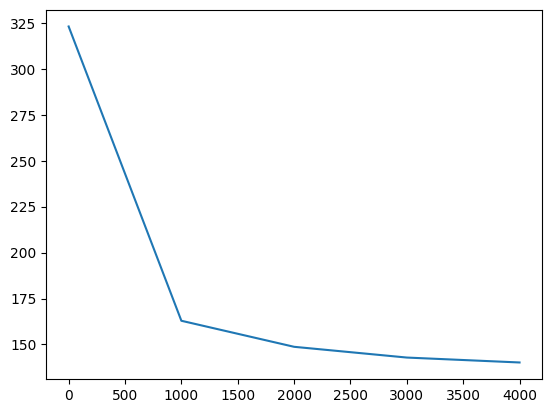

In [8]:
#------------------------------------------------------------------------------------------------------------------------------------
# NOTE: Number of latent dimensions, key hyper-parameter, 20~30 works for most of the cases.
K = 30
lamb = 0.001 
T = 4000     
interval = 1000
batch_size = 0.1
lr = 1e-2
seed = 0
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

#------------------------------------------------------------------------------------------------------------------------------------

start_time = time.time()
model = scmomat.scmomat_model(counts = counts, K = K, batch_size = batch_size, interval = interval, lr = lr, lamb = lamb, seed = seed, device = device)
losses = model.train_func(T = T)
end_time = time.time()
print("running time: " + str(end_time - start_time))

x = np.linspace(0, T, int(T/interval)+1)
plt.plot(x, losses)

## inference

In [9]:
umap_op = UMAP(n_components = 2, n_neighbors = 30, min_dist = 0.2, random_state = 0) 
zs = model.extract_cell_factors()
x_umap = umap_op.fit_transform(np.concatenate(zs, axis = 0))

In [10]:
# read in the ground truth labels
# NOTE: Plot the result before post-processing
input_test_sol = sc.read_h5ad(join(data_dir, 'openproblems_bmmc_cite_phase2_mod2.censor_dataset.output_test_sol.h5ad'))

test_ord = input_test_sol.X.tocsr().indices
assert (test_ord == np.argsort(input_test_sol.uns['pairing_ix'])).all()

labels = []
for bc in train_batches_barcodes:
    labels.append(df_meta.loc[bc, 'cell_type'].to_numpy())
for bc in test1_batches_barcodes:
    labels.append(df_meta.loc[bc, 'cell_type'].to_numpy())
    
df_test2 = pd.DataFrame(
    df_meta.loc[input_test_mod1.obs_names, 'cell_type'].to_list(), 
    index=input_test_mod2.obs_names[test_ord].to_list())
df_test2.columns = ['cell_type']

for bc in test2_batches_barcodes:
    labels.append(df_test2.loc[bc, 'cell_type'].to_numpy())

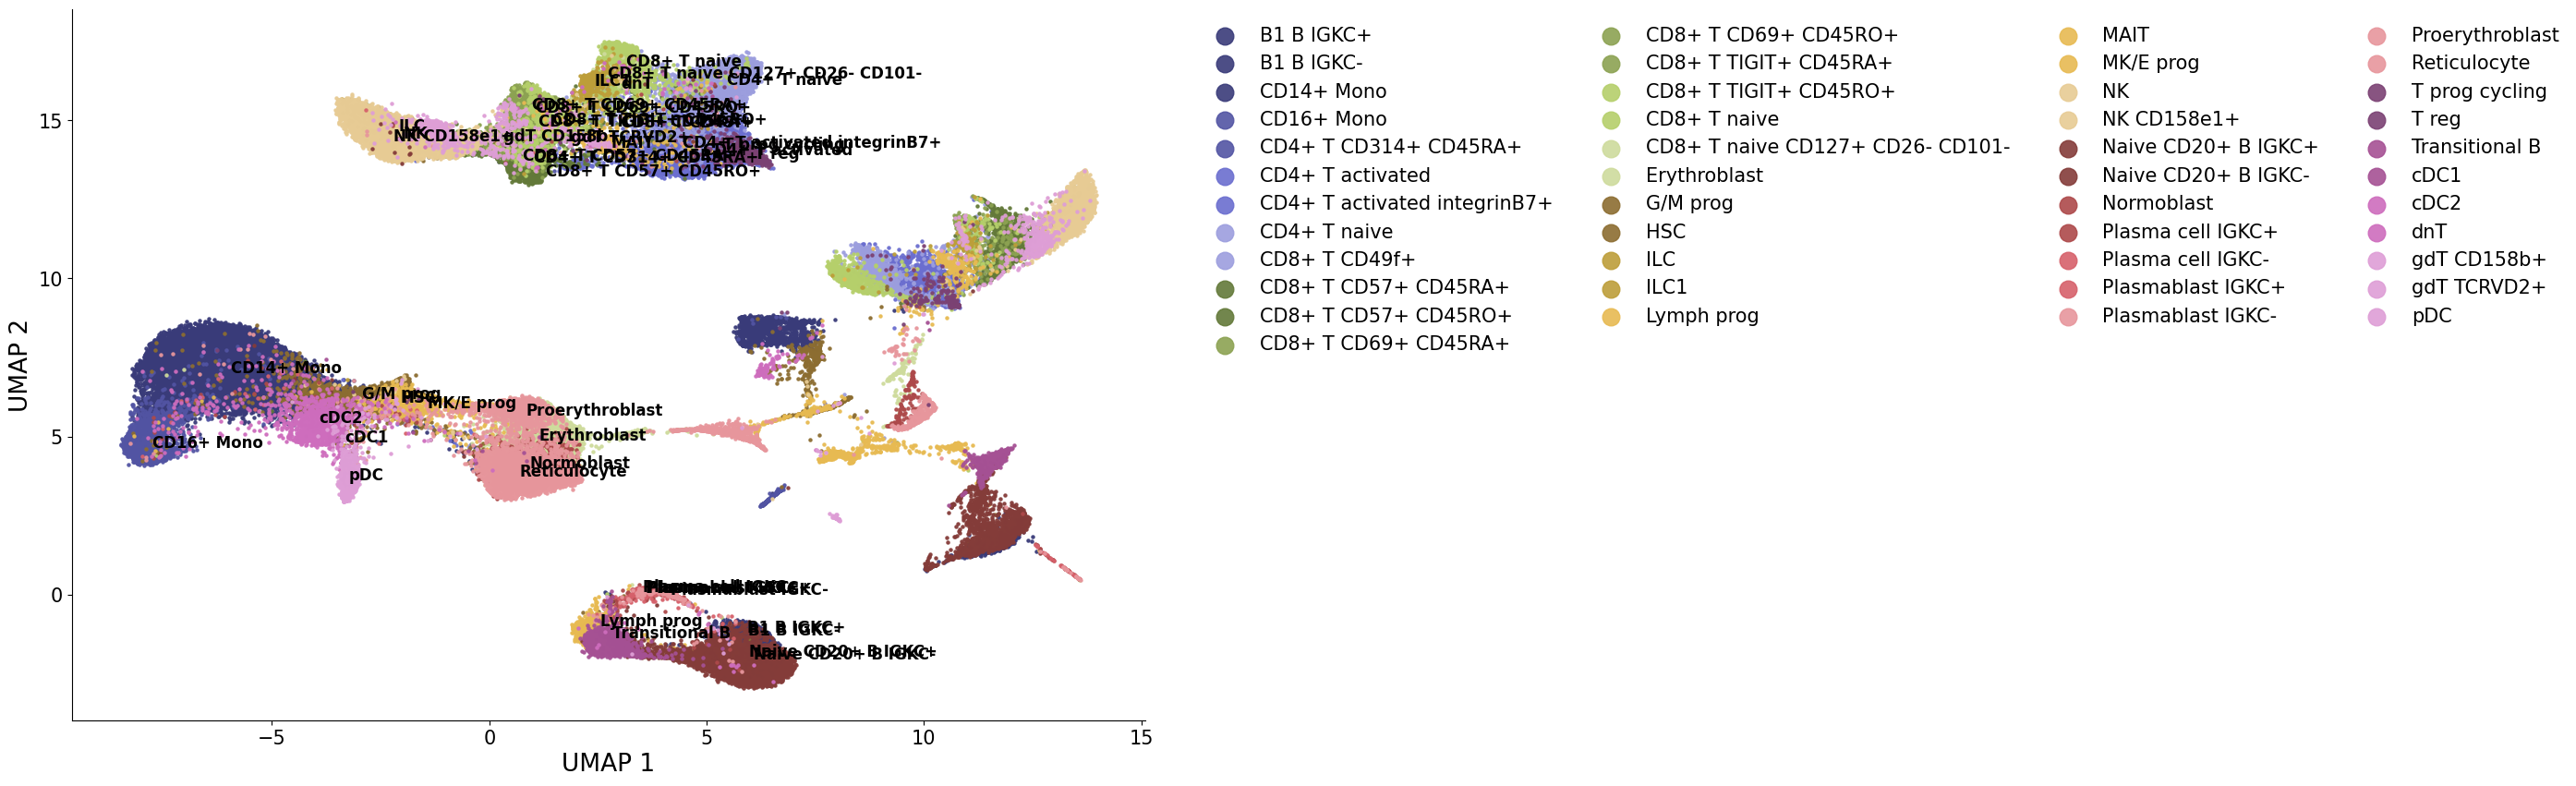

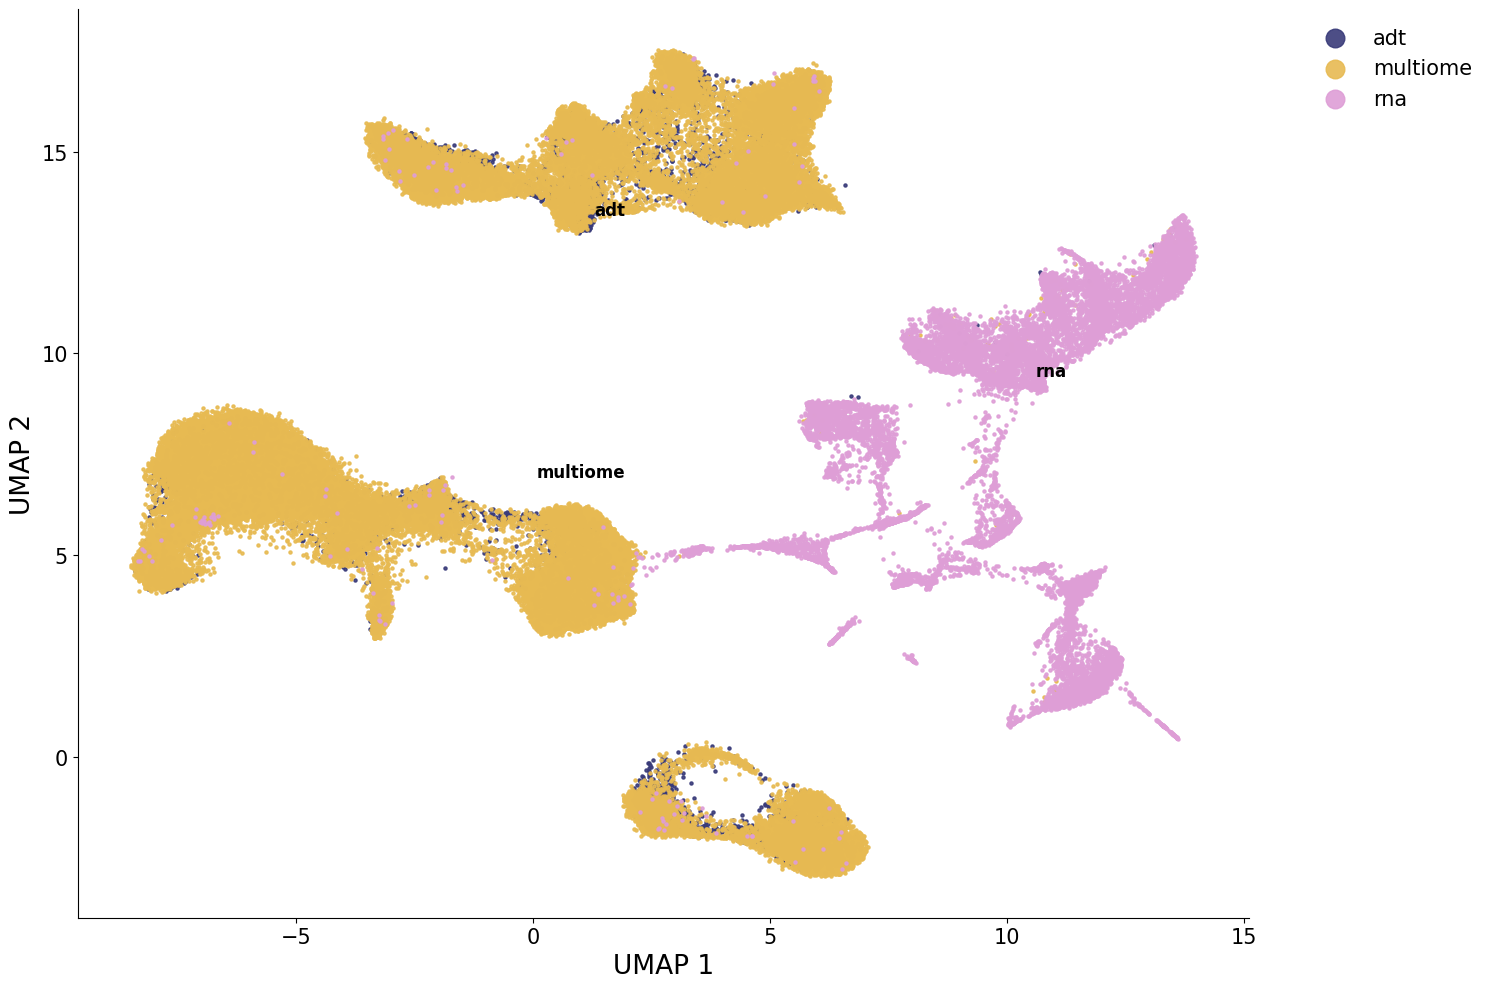

In [11]:
scmomat.plot_latent(x_umap, annos = np.concatenate(labels), 
                    mode = "joint", save = None, 
                    figsize = (15,10), axis_label = "UMAP", markerscale = 6, s = 5, label_inplace = True)
scmomat.plot_latent(x_umap, annos = np.concatenate(mods), 
                    mode = "joint", save = None, 
                    figsize = (15,10), axis_label = "UMAP", markerscale = 6, s = 5, label_inplace = True)

## Step 3: Post-processing
The hyper-parameter includes `n_neighbors` and `r`. Use `r = None` unless the cell type composition is highly unmatched. In the unmatched case, `r` can be set between `0.5` and `1`, where a smaller values means lower batch correction. `n_neighbors` should be adjusted according to the total number of batches, usually `5-15` for each batch would be enough.

calculating pairwise distance, time used 75.0755s
knn separate, time used 47.9918s
modify distance, time used 0.1490s
not unique
using precompute
Provided KNN...
random intialization...


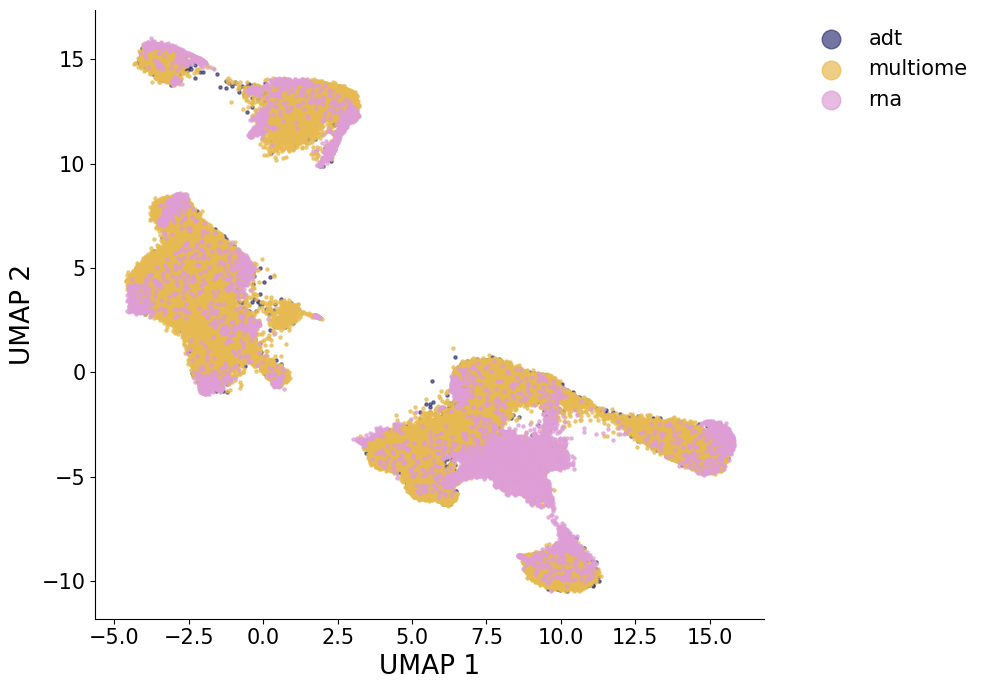

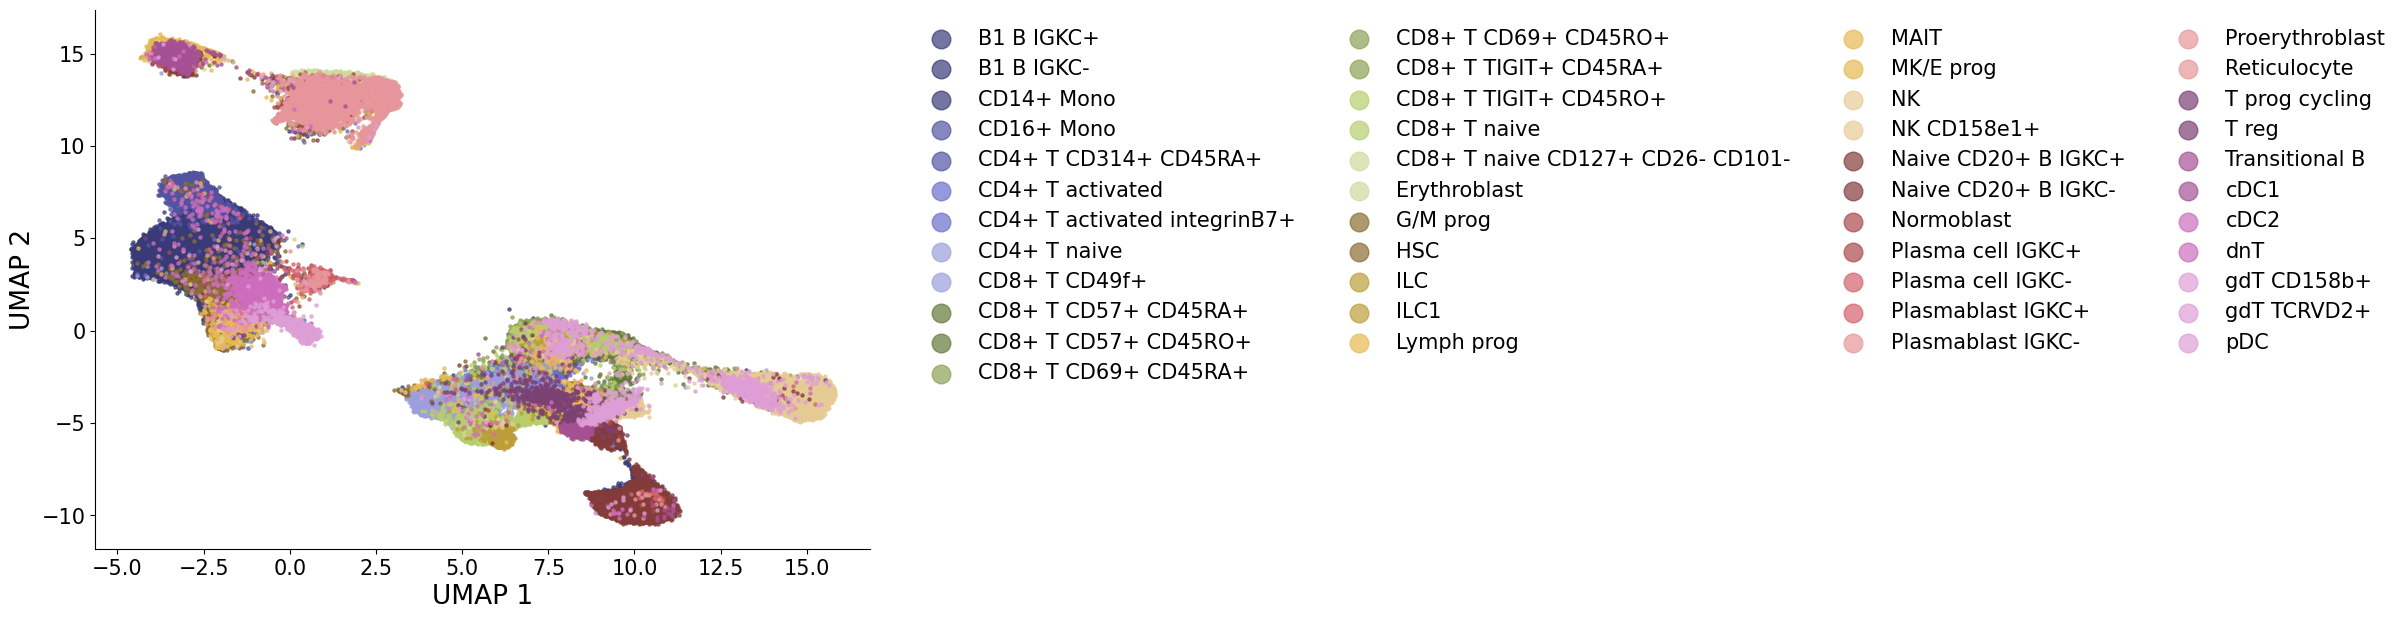

In [12]:
zs = model.extract_cell_factors()

n_neighbors = 100
r = None
resolution = 0.9
knn_indices, knn_dists = scmomat.calc_post_graph(zs, n_neighbors, njobs = 8, r = r)
# labels_leiden = scmomat.leiden_cluster(X = None, knn_indices = knn_indices, knn_dists = knn_dists, resolution = resolution)
x_umap = scmomat.calc_umap_embedding(
    knn_indices = knn_indices, knn_dists = knn_dists, 
    n_components = 2, n_neighbors = n_neighbors, min_dist = 0.20, random_state = 0)

scmomat.plot_latent(x_umap, 
                    annos=np.concatenate(mods),
                    mode = "joint", save = None,\
                      figsize = (10,7), axis_label = "UMAP", 
                    markerscale = 6, s = 5, label_inplace = False, alpha = 0.7)

scmomat.plot_latent(x_umap, 
                    annos=np.concatenate(labels),
                    mode = "joint", save = None,\
                      figsize = (10,7), axis_label = "UMAP", 
                    markerscale = 6, s = 5, label_inplace = False, alpha = 0.7)

# Eval results

In [13]:
ad_mosaic = sc.AnnData(np.vstack(zs), obsm={"X_emb":np.vstack(zs)})
ad_mosaic.obs['batch'] = np.hstack(batches)
ad_mosaic.obs['mod']   = np.hstack(mods)
ad_mosaic.obs['mod-batch'] = (ad_mosaic.obs['mod'] + '-' + ad_mosaic.obs.batch).to_numpy()
ad_mosaic.obs['cell_type'] = np.hstack(labels)

ad_mosaic.obsm['X_umap'] = x_umap

ad_mosaic.obsp['connectivities'] = scmomat.utils._compute_connectivities_umap(
    knn_indices = knn_indices, knn_dists = knn_dists, 
    n_neighbors = 15, set_op_mix_ratio=1.0, local_connectivity=1.0
)
ad_mosaic.uns['neighbors'] = {'connectivities_key':'connectivities'}

In [21]:
import sys
sys.path.insert(0, '/home/yanxh/gitrepo/multi-omics-matching/ACE/reproduce/evaluation')

from evaluation import eval_mosaic, eval_bridge, print_results, eval_lisi, eval_clustering

def get_umap(adata, use_rep='X_emb_shr'):
    sc.pp.neighbors(adata, n_neighbors=15, use_rep=use_rep)
    sc.tl.umap(adata)
    return adata

In [22]:
# mosaic eval
r = eval_mosaic(ad_mosaic, label_key='cell_type', batch_keys=['mod-batch', 'mod'], 
                use_lisi=True, use_gc=False, use_rep='X_emb', use_nmi=False, use_neighbors=True)

cell_type_LISI=0.95759
mod-batch_LISI=0.65725
mod_LISI=0.36873


In [23]:
# nmi, ari using nmi search
nmi, ari = eval_clustering(
    ad_mosaic, label_key='cell_type', cluster_key='cluster', resolutions=None, use_rep='X_emb', use_neighbors=True,
    use='nmi', nmi_method='arithmetic')
nmi, ari

(0.6392347561625938, 0.5972697506499282)

In [24]:
ad_adt_test = sc.AnnData(np.vstack(zs[-6:-3]), obsm={"X_emb":np.vstack(zs[-6:-3])})
ad_gex_test = sc.AnnData(np.vstack(zs[-3:]), obsm={"X_emb":np.vstack(zs[-3:])})
ad_adt_test.obs_names = np.hstack(barcodes[-6:-3])
ad_gex_test.obs_names = np.hstack(barcodes[-3:])
ad_adt_test.obs['batch'] = np.hstack(batches[-6:-3])
ad_gex_test.obs['batch'] = np.hstack(batches[-3:])
ad_adt_test.obs['cell_type'] = np.hstack(labels[-6:-3])
ad_gex_test.obs['cell_type'] = np.hstack(labels[-3:])

ad_adt_test = ad_adt_test[input_test_mod1.obs_names.to_numpy()].copy()
ad_gex_test = ad_gex_test[input_test_mod2.obs_names.to_numpy()][test_ord, :].copy()  # reorder
assert (ad_adt_test.obs.batch.to_numpy()==ad_gex_test.obs.batch.to_numpy()).all()

r = eval_bridge(
    ad_gex_test, ad_adt_test,
    label_key='cell_type',
    batch_key='batch',
    use_rep='X_emb',
    use_acc=False
)

FOSCTTM=0.13281
Match_score=0.00249


## Save plots

In [14]:
def get_umap(adata, use_rep='X_emb_shr', add_key=None):
    sc.pp.neighbors(adata, n_neighbors=15, use_rep=use_rep)
    sc.tl.umap(adata)
    
    add_key = 'X_umap' if add_key is None else add_key
    adata.obsm[add_key] = adata.obsm['X_umap']
    return adata

def save_umap(adata, use_rep, colors, is_title='', legend_loc=None, save_dir=None, prefix_name=None):
    for c in colors:
        sc.pl.embedding(adata, basis=use_rep, color=[c], legend_fontsize=4, legend_loc=legend_loc,
              frameon=False, legend_fontoutline=2, show=False, title=is_title) # cmap=reds, vmin=0.00001, 
        plt.savefig(f"{save_dir}/{prefix_name}_{c}_legend={legend_loc}.jpg", bbox_inches="tight", dpi=300)

In [20]:
modD = {'adt':'other', 'multiome':'multiome', 'rna':'gex'}
ad_mosaic.obs['mod2'] = [modD[_] for _ in ad_mosaic.obs['mod']]
ad_mosaic.obs['mod-batch2'] = ad_mosaic.obs['mod2'].astype('str') + '-' + ad_mosaic.obs.batch.astype('str')

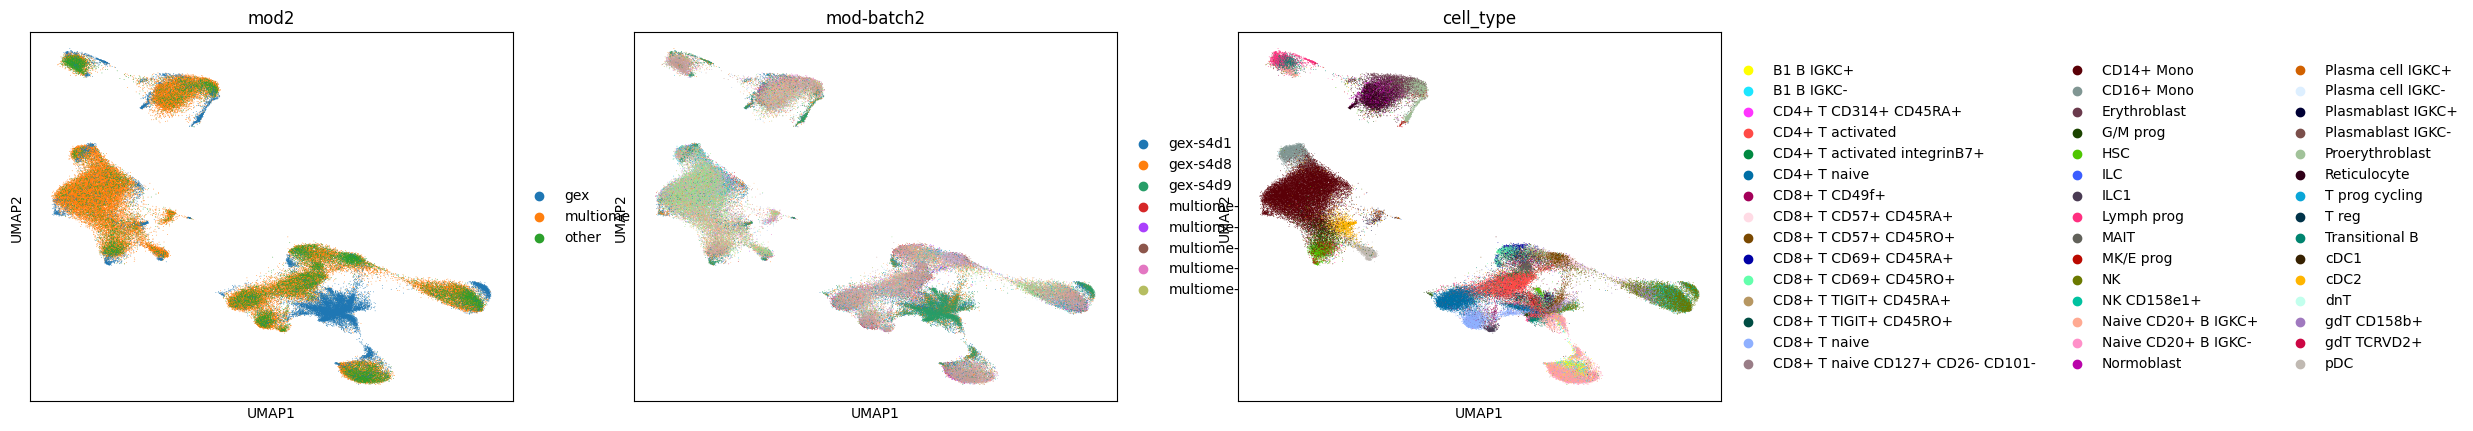

In [22]:
sc.pl.umap(ad_mosaic, color=['mod2', 'mod-batch2', 'cell_type'])

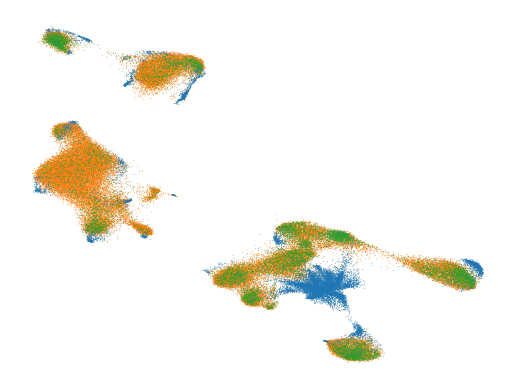

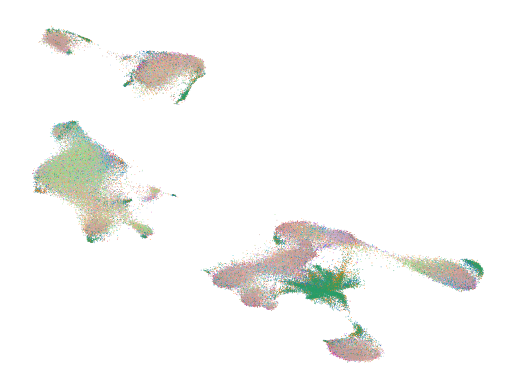

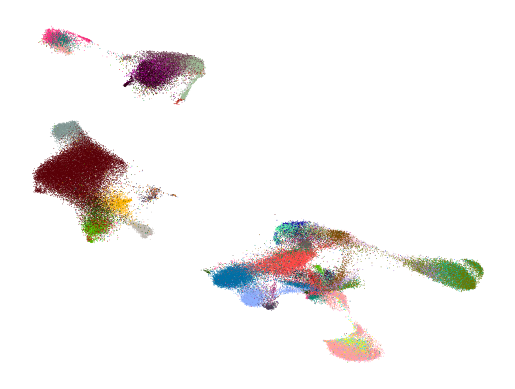

In [23]:
umap_save_dir = '/home/sda1/yanxh/outputs/umap_plots'

save_umap(ad_mosaic, 'X_umap', ['mod2', 'mod-batch2', 'cell_type'], is_title='', legend_loc=None, 
          save_dir='/home/yanxh/gitrepo/multi-omics-matching/Visualization/Figures/sec1/umap', 
          prefix_name='scMoMaT_case2_cite_stage2')

In [24]:
np.save(join(umap_save_dir, 'scMoMaT_case2_cite_umap.npy'), ad_mosaic.obsm['X_umap'])